# Прогнозирование оттока клиентов

**Краткое описание:**<br>
Оператору связи требуется прогноз того, какой клиент с большой вероятностью может уйти. Чтобы удержать таких клиентов, оператор планирует проведение персонифицированных акций (например, бонусы, скидки и т.п.). Для работы над задачей предоставлено четыре таблицы с данными о клиентах и услугах, которыми они пользуются.

**Цель:**<br>
Разработать алгоритм, который будет выявлять тех клиентов компании-заказчика, которые могут в скором времени уйти. Метрикой качества служит ROC_AUC.


**План проекта:**<br>
1. Исследовательский анализ данных (EDA)
        1.1 Загрузка данных. Сшивание из них единого датасета.
        1.2 Проверка на дубликаты.
        1.3 Исследование структуры данных. Построения гистограмм и распределений основных величин.
        1.4 Проверка на пропуски. Заполнение пропусков.
        1.5 Проверка на мультиколлинеарность.

2. Подготовка данных для обучения моделей
        2.1 Генерация дополнительных признаков
        2.2 Кодировка категориальных данных
        2.3 Нормировка и скейлинг
        2.4 Деление на тренировочную и тестовую выборки
    
3. Обучение моделей
        3.1 Линейная модель (ЛогРег)
        3.2 Лес
        3.3 Бустинг
        3.4 Выбор лучшей модели

4. Тестирование лучшей модели

5. Вывод


## Исследовательский анализ данных

### Загрузка данных и формирование единого датасета

In [1]:
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import phik
from phik import report
from phik.report import plot_correlation_matrix
import random

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 240423
random.seed(RANDOM_STATE)

In [2]:
contract = pd.read_csv(r'https://code.s3.yandex.net/datasets/contract_new.csv')
personal = pd.read_csv(r'https://code.s3.yandex.net/datasets/personal_new.csv')
internet = pd.read_csv(r'https://code.s3.yandex.net/datasets/internet_new.csv')
phone = pd.read_csv(r'https://code.s3.yandex.net/datasets/phone_new.csv')

In [3]:
display(contract.sample(5))
display(personal.sample(5))
display(internet.sample(5))
display(phone.sample(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3302,7774-OJSXI,2017-05-01,No,One year,Yes,Electronic check,103.45,3413.85
1183,0887-WBJVH,2015-09-01,No,One year,Yes,Electronic check,93.45,5448.14
2841,9743-DQKQW,2019-11-01,No,Month-to-month,No,Electronic check,25.10,82.83
743,4018-PPNDW,2015-01-01,No,Two year,Yes,Mailed check,24.10,1470.1
6890,7470-DYNOE,2015-09-01,No,One year,Yes,Electronic check,61.10,3238.3


,customerID,gender,SeniorCitizen,Partner,Dependents
1491,8605-ITULD,Female,0,No,No
550,3580-HYCSP,Male,0,Yes,Yes
944,6353-BRMMA,Female,0,Yes,Yes
3238,7850-THJMU,Female,0,Yes,Yes
6914,7142-HVGBG,Male,1,Yes,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3458,5278-PNYOX,Fiber optic,No,No,Yes,Yes,Yes,Yes
5433,2898-MRKPI,Fiber optic,No,Yes,No,No,Yes,Yes
4748,3063-QFSZL,DSL,No,No,No,No,No,Yes
752,5709-LVOEQ,DSL,Yes,Yes,Yes,No,Yes,Yes
4513,1818-ESQMW,Fiber optic,No,No,Yes,Yes,No,Yes


,customerID,MultipleLines
149,6345-FZOQH,No
3475,8819-ZBYNA,Yes
5286,9112-WSNPU,No
168,0956-SYCWG,No
6163,3005-NFMTA,Yes


Для сохранения общности переименование столбцов:
    
 gender в Gender, customerID в CustomerID

In [4]:
contract.rename(columns={'customerID': 'CustomerID'}, inplace=True)
personal.rename(columns={'gender': 'Gender', 'customerID': 'CustomerID'}, inplace=True)
internet.rename(columns={'customerID': 'CustomerID'}, inplace=True)
phone.rename(columns={'customerID': 'CustomerID'}, inplace=True)

In [5]:
df = contract.merge(personal, on='CustomerID', how='outer') \
    .merge(internet, on='CustomerID', how='outer') \
    .merge(phone, on='CustomerID', how='outer')

In [6]:
df.sample(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
44,4080-IIARD,2019-01-01,No,Month-to-month,Yes,Electronic check,76.20,990.6,Female,0,Yes,No,DSL,Yes,Yes,No,Yes,Yes,No,Yes
5694,0983-TATYJ,2017-05-01,No,One year,Yes,Mailed check,51.45,1697.85,Female,0,Yes,No,DSL,No,No,No,Yes,No,No,No
6981,5568-DMXZS,2019-06-01,No,Month-to-month,Yes,Electronic check,65.45,549.78,Female,0,No,No,DSL,No,Yes,No,Yes,Yes,No,No
1475,6048-UWKAL,2014-05-01,No,Two year,No,Credit card (automatic),105.40,7272.6,Female,1,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Yes
2526,5766-ZJYBB,2019-11-01,No,Month-to-month,No,Mailed check,19.40,58.2,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [8]:
df.describe()

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


### Проверка на дубликаты 

In [9]:
print('number of unique CustomerID:', df['CustomerID'].nunique())
print('number of duplicates:', df.duplicated().sum())

number of unique CustomerID: 7043
number of duplicates: 0


дубликатов нет :)

### Предварительный анализ данных

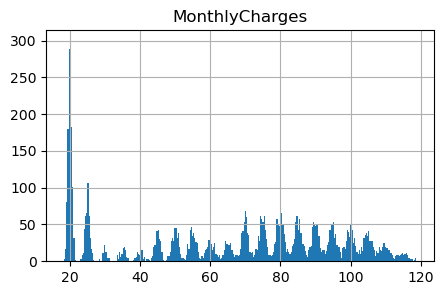

In [10]:
plt.figure(figsize=(5,3))
plt.rcParams["figure.figsize"] = [5, 3]
plt.hist(df['MonthlyCharges'], bins=300)
plt.title('MonthlyCharges')
plt.grid()
plt.show()


Тут видно высокочастотную модуляцию с периодом в 5у.е. Возможно, это связано с тем, что ежемесячные траты большинства пользователей кратны этим пяти у.е.
А еще можно увидеть три наложившихся друг на друга распределения с разной полушириной, с которыми можно ассоциировать три разные группы пользователей. Первый пик, узкий и высокий - это те, кто платит 20-25 у.е. Второй пик, шире и низкий - те, кто платят 45-55у.е. И третий, самое широкое распределение - это те, кто тратят примерно 70-100 у.е.

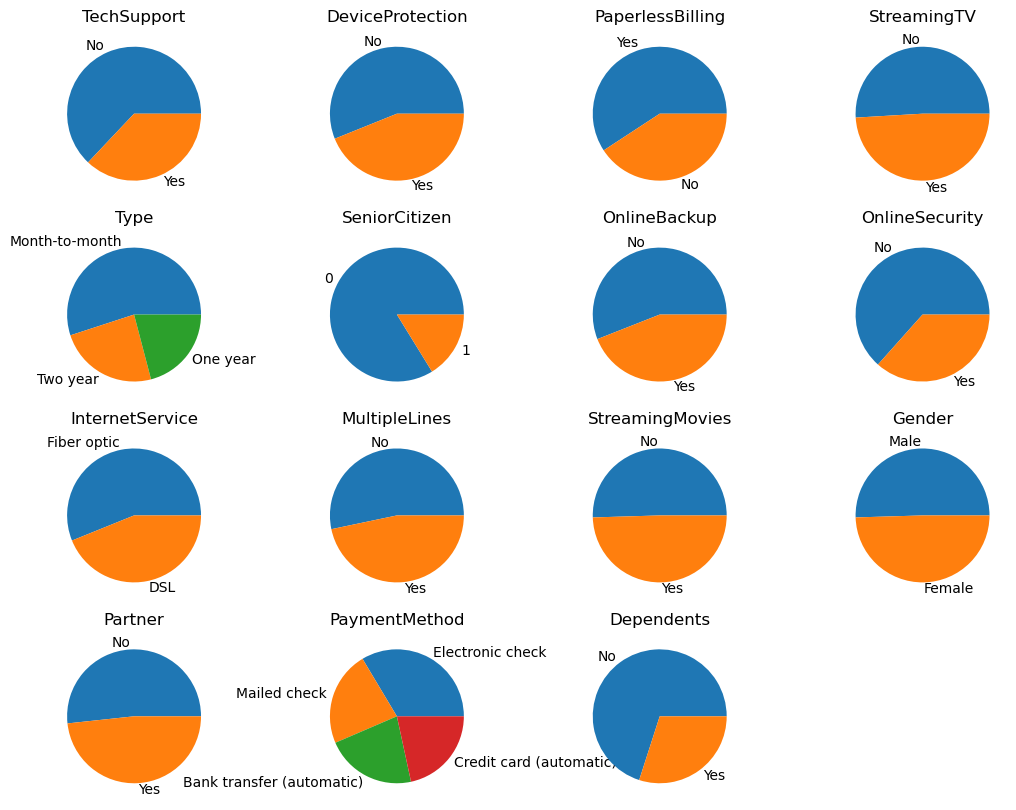

In [11]:
all_columns = set(df.columns)
columns = all_columns - {
    'MonthlyCharges',
    'TotalCharges',
    'CustomerID',
    'BeginDate',
    'EndDate'
}

i = 1
plt.figure(figsize=(13, 10))
for col in columns:
    plt.subplot(4, 4, i)
    val = df[col].value_counts()
    plt.pie(val, labels=val.index)
    plt.title(col)
    i += 1

plt.show()


 Абсолютное большинство признаков - категориальные и бинарные (это значит, что для кодирования лучше всего подойдет OHE). 

In [12]:
df_na = df.isna().sum()
col_na = df_na[df_na > 0].index.to_list()
print('В каких колонках есть пропуски:\n', col_na)

В каких колонках есть пропуски:
 ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


В колонке TotalCharges следует поменять тип на числовой, но при попытке - вылетает ошибка. Не все записи преобразуются во float. Посмотрим, что тут не так.

In [13]:
# функция, отвечает на вопрос: можно ли перевести во float?
def is_not_float(x):
    try:
        float(x)
        return False
    except:
        return True

    print(f'В колонке TotalCharges имеется {df["TotalCharges"].apply(is_not_float).sum()} записей,\
которые нельзя перевести в число. Вот они.')

# индексы этих записей, где значение в TotalCharges - не  float
indx = df[df['TotalCharges'].apply(is_not_float)==1].index
df.iloc[indx]
       

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Эти записи объединяет общая дата заключения договора. И она совпадает с датой выгрузки информации, т.е. 2020-02-01.
Что с ними делать:  можно удалить (11 штук - это десятые процента датасета, поэтому погоды не сделают), а можно и заполнить (нулями или значениями из MonthlyCharges). Я удалю, потому что их количество ничтожно мало.

Спойлер. Если пустые строки в признаке total_charges заменить месячными значениями платежей, то в итоге на валидации метрика подскочит на 0.005, а на тестовой выборке напротив, упадет на 0.008.

In [14]:
df.loc[indx,'TotalCharges'] = df.loc[indx, 'MonthlyCharges']
df['TotalCharges'] = df['TotalCharges'].astype(float)

Преобразуем тип колонки SeniorSitizen в object: по подобию всех остальных категориальных колонок в этом датасете.

In [15]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

Теперь разберемся с колонками, где записаны даты. Преобразуем тип, и посмотрим, что там лежит.

In [16]:
# преобразуем тип
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')

# проверка
#df.info()
#df.sample(15)

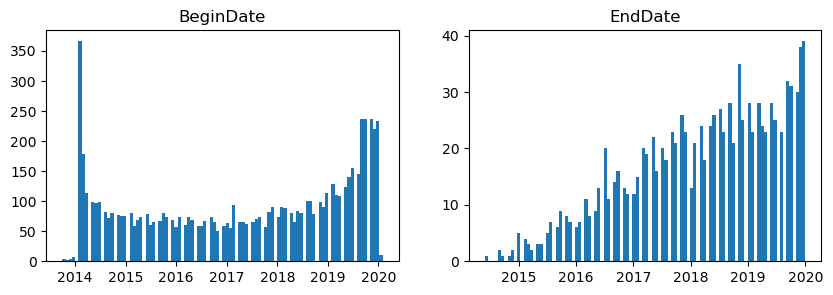

сколько раз EndDate была позже, чем BeginDate: 0


In [17]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(df['BeginDate'], bins=100)
plt.title('BeginDate')
plt.subplot(1,2,2)
plt.hist(df['EndDate'], bins=100)
plt.title('EndDate')
plt.show()

print('сколько раз EndDate была позже, чем BeginDate:', (df['EndDate'] < df['BeginDate']).sum())

Даты выглядят правдоподобно, все в пределах нашего века, а дата завершения договора ни разу не случилась раньше, чем дата подписания. Можно теперь из этих дат сгенерировать новый признак: "как долго клиент пользуется услугами компании". Этот признак будет называться 'ClientLife'. Это будет продолжительность договора в случае если договор закрыт, а в случае, если не закрыт - время от начала договора до 01.02.2020 </br>
Кроме этого, сгенерируем столбец, который потом станет таргетом. Если клиент ушел (т.е. если договор закрыт), то поставим в этот стобец 1. Если клиент все еще пользуется услугами компании - тогд 0. Этот признак будет называться 'Betrayer'.</br>

In [18]:
# новая колонка 'ClientLife' с продолжительностью договора клиента
df['ClientLife'] = df.apply(
    lambda x: (pd.to_datetime('2020-02-01') - x['BeginDate'])  if pd.isnull(x['EndDate'])
    else (x['EndDate'] - x['BeginDate']), axis=1
)

# новая колонка 'Betrayer' - ушел клиент или нет
df['Betrayer'] = np.where(df['EndDate'].isna(), 0, 1)
# проверка
#df.head(10)

Сделаем признак ClientLife в формате Int (количество дней).
Удалим колонки BeginDate и EndDate, чтобы не было утечки данных.

In [19]:
#print('сколько максимально дней бывало:', df['ClientLife'].dt.days.max())
df['ClientLife'] = df['ClientLife'].dt.days.astype('Int32')
df = df.drop(columns=['BeginDate', 'EndDate'])

#проверка
#df.info()

Введем новый признак: сколько услуг, подключено у клиента. Для этого переведем значения в колонках с услугами в 1 если есть услуга и 0, если нет. Плюс учтем тех клиентов, которые пользуются и телефоном и интернетом.

  Создаем новый датафрейм services_int_df с одной колонкой - ID клиента. Потом заполняем этот датафрейм бинарными значениями, соответствующими наличию услуги (0 или 1). Названия колонок с услугами хранятся в переменной col_services.
    Потом создаем список юзеров inet_phone_customers, у которых и телефон и интернет одновременно. И генерируем новую колонку 'InetPhone' в services_int_df, в которой проставим дополнительную единичку тем, кто имеет и телефон и интернет. После этого рассчитываем сумму всех услуг 'ServicesAmount' и добавляем эту новую колонку с суммой в наш датасет df.

In [20]:
col_services = set(internet.columns).union(phone.columns) - {'CustomerID', 'InternetService'}

services_int_df = pd.DataFrame(df['CustomerID'])

for col in col_services:
    services_int_df[col] = df[col].where(df[col]=='Yes', 0) 
    services_int_df[col] = services_int_df[col].where(df[col]!='Yes', 1) 
    
#display(services_int_df.sample(5)) # проверка что получилось
inet_phone_customers = pd.merge(internet, phone)['CustomerID']
#display(inet_phone_customers) # проверка

services_int_df['InetPhone'] = [0] * services_int_df.shape[0]
services_int_df['InetPhone'].where(~services_int_df['CustomerID'].isin(inet_phone_customers), 1, inplace=True)
services_int_df['ServicesAmount'] = services_int_df.drop(columns='CustomerID').sum(axis=1)
df = services_int_df[['CustomerID', 'ServicesAmount']].merge(df)
#df.head()

Попробуем добавить еще один признак! Категорию юзера по тому, сколько он ежемесячно платим. Разделим всех юзеров на три типа, согласно их ежемесячным платежам. </br>
- до 35 у.е. - назовем их 'Poor' </br>
- от 35 до 62.5 у.е. -назовем их 'Standard' </br>
- более 62.5 - - назовем их 'Rich' </br>
    Создадим новую колонку в датасете df с категориями граждан, назовем ее 'HowRich'.
    
    
Спойлер. Бесполезный признак оказался, в хвосте рейтинга feature_importance. Да и метрики с ним практически не изменились.

In [21]:
def UserCat(x):
    if x < 35:
        return 'Poor'
    if x < 62.5:
        return 'Standard'
    else:
        return 'Rich'
    
df['HowRich'] = df['MonthlyCharges'].apply(UserCat)
#df.sample(10)

Насколько несбалансированный целевой признак (он же 'Betrayer')

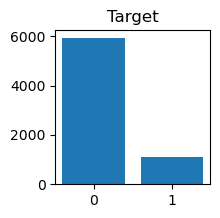

Ratio of imbalance: 5.4


In [22]:
trgt_cnt = df['Betrayer'].value_counts()
plt.figure(figsize=(2,2))
plt.bar(trgt_cnt.index, trgt_cnt)
plt.title('Target')
plt.show()
print('Ratio of imbalance:', round(trgt_cnt.max() / trgt_cnt.min(), 1))

Данные сильно несбалансированы, в целевом признаке количество клиентов, покинувших опрератора связи - в пять раз меньше тех, кто еще не покинул.

### Заполнение пропусков

Проверка наличия пропусков в исходных датасетах по отдельности

In [23]:
display(contract.isna().sum())
display(personal.isna().sum())
display(internet.isna().sum())
display(phone.isna().sum())

CustomerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

CustomerID       0
Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

CustomerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

CustomerID       0
MultipleLines    0
dtype: int64

Проверка наличия пропусков в сшитом едином датасете

In [24]:
df.isna().sum()

CustomerID             0
ServicesAmount         0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
ClientLife             0
Betrayer               0
HowRich                0
dtype: int64

В исходных таблицах пропусков нет, но они появляются после их объединения. Все пропуски - в колонках с категориальными значениями, посмотрим какие там варианты (кроме колонки 'EndDate', про нее мы уже знаем).

In [25]:
df_na = df.isna().sum()
col_na = set(df_na[df_na > 0].index)
print('В каких колонках есть пропуски и какого типа значения в них встречаются:\n')
for col in col_na:
    print(col, ':', df[col].unique())

В каких колонках есть пропуски и какого типа значения в них встречаются:

TechSupport : ['No' 'Yes' nan]
DeviceProtection : ['No' 'Yes' nan]
StreamingTV : ['No' 'Yes' nan]
OnlineBackup : ['Yes' 'No' nan]
InternetService : ['DSL' 'Fiber optic' nan]
MultipleLines : [nan 'No' 'Yes']
StreamingMovies : ['No' 'Yes' nan]
OnlineSecurity : ['No' 'Yes' nan]


Такие пропуски можно заполнить значением 'No', которое будет символизировать отсутствие услуги у клиента.

In [26]:
# заполняем все одним махом
df[list(col_na)] = df[list(col_na)].fillna('No')
# проверка
#print(df.isna().sum())

### Проверка на мультиколлинеарность

In [27]:
phik_overview = df.phik_matrix()
#phik_overview.round(2)

interval_cols = ['MonthlyCharges', 'TotalCharges', 'ClientLife']
phik_overview = df.phik_matrix(interval_cols=interval_cols)


interval columns not set, guessing: ['ServicesAmount', 'MonthlyCharges', 'TotalCharges', 'ClientLife', 'Betrayer']


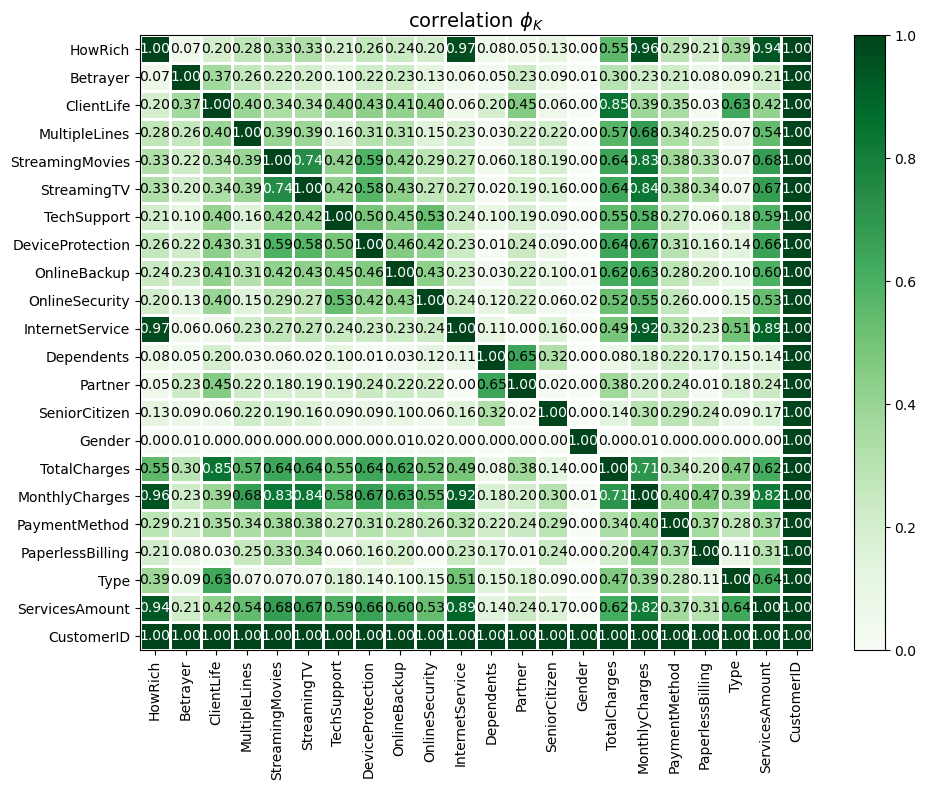

In [28]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        figsize=(10, 8))
plt.tight_layout()

Самая существенная корреляция между колонками InternetService/MonthlyCharges (0.92), TotalCharges/ClientLife(0.85), MonthlyCharges/StreamingMovies и StreamingTV (0.83 и 0.84).
Поэтому, в случае линейной модели, признак MonthlyCharges лучше удалить. И ClientLife c ServicesAmount -- тоже.

### Портрет уходящего клиента

Посмотрим как выглядит тот, кто уходит.

Отнормированные гистограммы для продолжительности жизни уходящих клиентов и их ежемесячных трат.

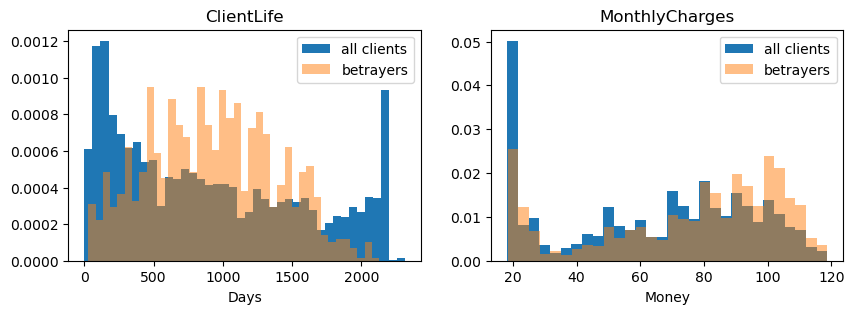

In [29]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(df['ClientLife'], bins=40, density=True, label='all clients')
plt.hist(df['ClientLife'][df['Betrayer']==1], density=True, alpha=0.5, bins=40, label='betrayers')
plt.title('ClientLife')
plt.xlabel('Days')
plt.legend()
plt.subplot(122)
plt.hist(df['MonthlyCharges'],bins=30, density=True,  label='all clients')
plt.hist(df['MonthlyCharges'][df['Betrayer']==1],density=True, alpha=0.5, bins=30, label='betrayers')
plt.title('MonthlyCharges')
plt.xlabel('Money')
plt.legend()
plt.show()

Клиенты уходят через 1000+-500 дней. Тот, кто ушел - платил каждый месяц немного больше.

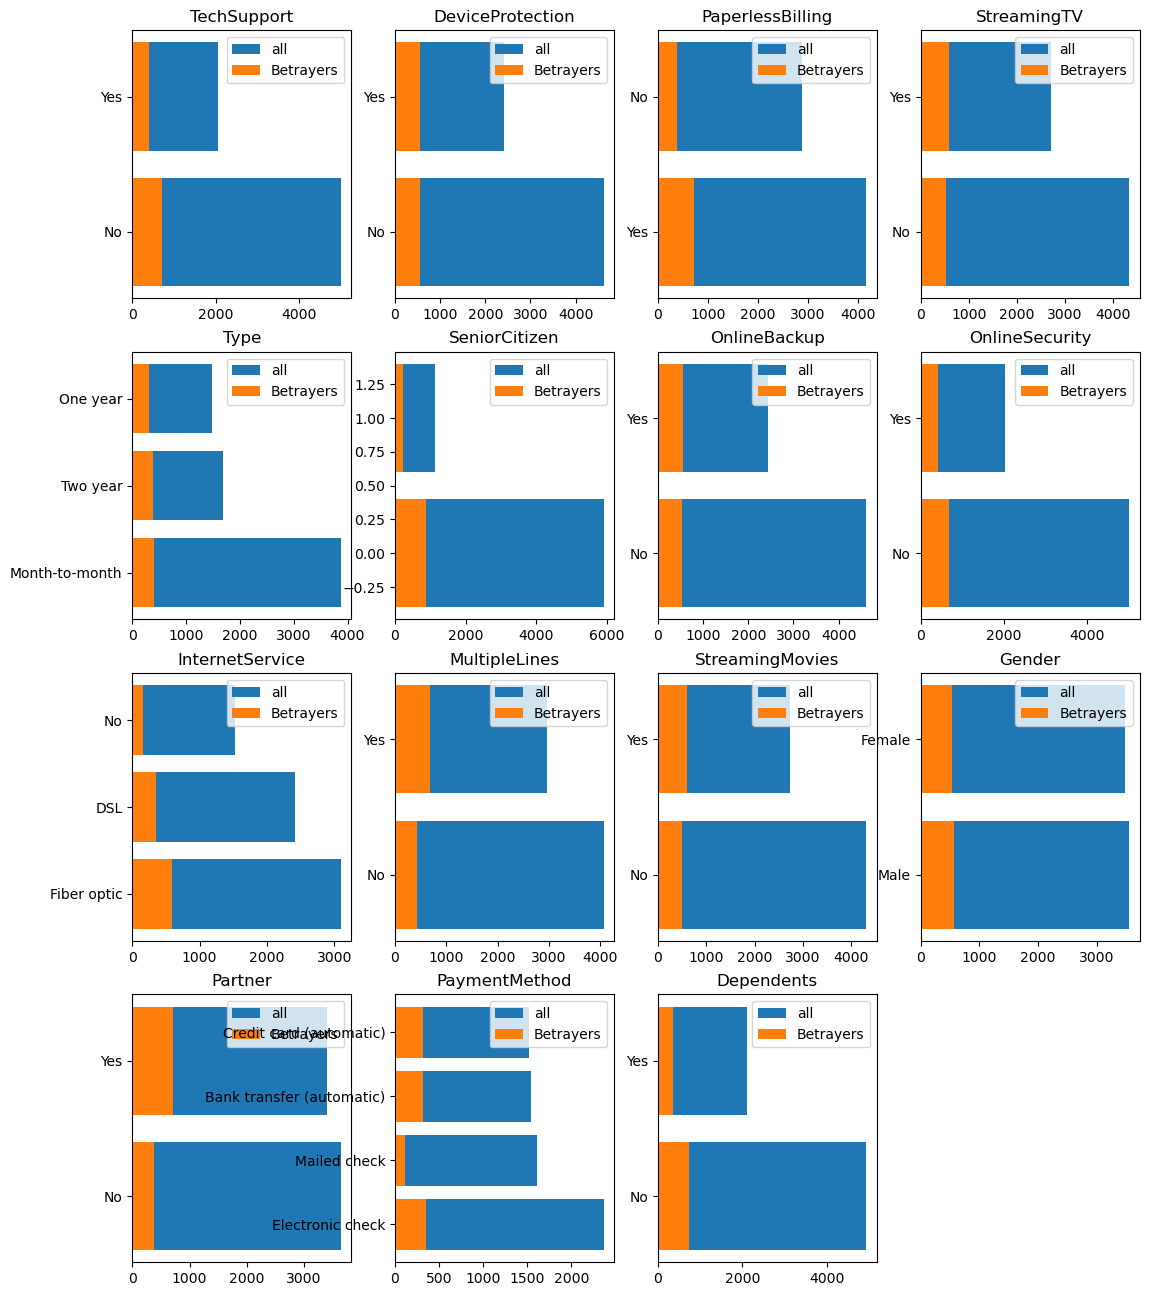

In [30]:
plt.figure(figsize=(13,16))
i = 1
for col in columns:
    plt.subplot(4, 4, i)
    all_clients = df[col].value_counts()
    betrayers = df[df['Betrayer']==1][col].value_counts()
    plt.barh(all_clients.index, all_clients, label='all')
    plt.barh(betrayers.index, betrayers, label='Betrayers')
    plt.title(col)
    plt.legend()
    i += 1
plt.show()


Тут было бы правильнее рассчитывать относительные доли уходящих клиентов в каждой категории. Но из картинок можно тоже сделать ряд любопытных наблюдений: </br>
чаще уходят те,  </br>
- у кого есть партнер </br>
- кто делает бекап и защиту устройств </br>
- у кого несколько параллельных телефонных линий  </br>
- кто смотрит стриминговые видео </br>
А вот те, кто платят ежемесячно или по чеку (электронному или почтовому) - уходят реже, чем те кто имеют годовой(двухгодичный) тип оплаты и пользуется банковским переводом/кредитной картой. 

## Подготовка данных для обучения моделей

Деление датасета на тренировочный и тестовый с учетом дисбаланса целевого признака. Выделение отдельного датасета для логистической регрессии (без мультиколллинеарных столбцов). Создание списка категориальных столбцов для кодирования.

 Создаем отдельный тренировочный датасет только для логисической регрессии X_train_logreg. Генерируем список категориальных признаков cat_features для ohe и список всех интервальных признаков num_features.

In [31]:
train, test = train_test_split(df.drop(columns='CustomerID'), test_size=0.25, stratify=df['Betrayer'], random_state=RANDOM_STATE)
X_train = train.drop(columns='Betrayer')
y_train = train['Betrayer']

X_train_logreg = X_train.drop(columns=['MonthlyCharges', 'ClientLife', 'ServicesAmount'])

X_test = test.drop(columns='Betrayer')
X_test_logreg = X_test.drop(columns=['MonthlyCharges', 'ClientLife', 'ServicesAmount'])
y_test = test['Betrayer']

cat_features = X_train.select_dtypes(include='object').columns.to_list()
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features_logreg = ['TotalCharges']

## Обучение моделей

Логистическая регрессия

In [32]:
%%time

num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

cat_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop='first', handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features_logreg),
        ("cat", cat_transformer, cat_features),
    ]
)

param_LR={'model__C': range(1, 11, 1),
         'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
         }

pipeline = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('model', LogisticRegression(class_weight='balanced'))
          ]
)

GS_LR = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_LR, scoring='roc_auc')

GS_LR.fit(X_train_logreg, y_train)
print('model LogReg, roc_auc_score =', round(GS_LR.best_score_,3))
print('model LogReg, best parameters:\n',  GS_LR.best_params_, '\n')


model LogReg, roc_auc_score = 0.773
model LogReg, best parameters:
 {'model__C': 1, 'model__solver': 'liblinear'} 

Wall time: 4.14 s


Дерево

In [33]:
%%time

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ]
)


param_tree = {
    'model__max_depth': range(1, 20, 1),
    'model__min_samples_split': range(2, 5, 1)
}

pipeline = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('model', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
          ]
)

RS_tree = RandomizedSearchCV(pipeline, cv=5, n_jobs=-1, param_distributions=param_tree, scoring='roc_auc')

RS_tree.fit(X_train, y_train)
print('model Tree, roc_auc_score =', round(RS_tree.best_score_,3))
print('model Tree, best parameters:\n',  RS_tree.best_params_, '\n')

model Tree, roc_auc_score = 0.786
model Tree, best parameters:
 {'model__min_samples_split': 3, 'model__max_depth': 6} 

Wall time: 716 ms


Лес

In [34]:
%%time

param_forest = {
    'model__max_depth': range(7, 15, 1),
    'model__min_samples_split': range(2, 5),
    'model__min_samples_leaf': range(2, 5),
    'model__n_estimators': range(800, 1200, 20)
}

pipeline = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('model',  RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
          ]
)

RS_forest = RandomizedSearchCV(pipeline, cv=5, n_jobs=-1, param_distributions=param_forest, scoring='roc_auc')

RS_forest.fit(X_train, y_train)
print('model Forest, roc_auc_score =', round(RS_forest.best_score_,3))
print('model Forest, best parameters:\n',  RS_forest.best_params_, '\n')

model Forest, roc_auc_score = 0.823
model Forest, best parameters:
 {'model__n_estimators': 1020, 'model__min_samples_split': 4, 'model__min_samples_leaf': 4, 'model__max_depth': 12} 

Wall time: 40.5 s


Бустинг (LGBM)

In [35]:
%%time
param_lgbm = {
    'model__num_leaves': range(3, 10, 1),
    'model__max_depth': range(12, 25, 1),
    'model__n_estimators': range(600, 1000, 10)
}

pipeline = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('model',  LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE))
          ]
)
RS_lgbm = RandomizedSearchCV(pipeline, cv=5, n_jobs=-1, param_distributions=param_lgbm, scoring='roc_auc')

RS_lgbm.fit(X_train, y_train)
print('model LGBM, roc_auc_score =', round(RS_lgbm.best_score_,3))
print('model LGBM, best parameters:\n', RS_lgbm.best_params_, '\n')

model LGBM, roc_auc_score = 0.894
model LGBM, best parameters:
 {'model__num_leaves': 6, 'model__n_estimators': 840, 'model__max_depth': 22} 

Wall time: 5.3 s


CatBoost

In [36]:
%%time
param_cb = {
    'model__iterations': range(650, 800, 5),
    'model__learning_rate': np.logspace(-1, 0, 20),
    'model__depth': range(4, 6, 1)
}

pipeline = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('model', CatBoostClassifier( auto_class_weights='Balanced', silent=True, random_state=RANDOM_STATE))
          ]
)
RS_cb = RandomizedSearchCV(pipeline, cv=5, n_jobs=-1, param_distributions=param_cb, scoring='roc_auc')

RS_cb.fit(X_train, y_train)
print('model CatBoost, roc_auc_score =', round(RS_cb.best_score_,3))
print('model CatBoost, best parameters:\n', RS_cb.best_params_, '\n')

model CatBoost, roc_auc_score = 0.908
model CatBoost, best parameters:
 {'model__learning_rate': 0.37926901907322497, 'model__iterations': 690, 'model__depth': 4} 

Wall time: 30.5 s


KNN

In [37]:
param_knn = {
    'model__n_neighbors': range(50, 80, 1)
}
    
    
KNN_model = KNeighborsRegressor(n_jobs=-1)
pipeline = Pipeline(
    steps=[('preprocessor',preprocessor),
           ('model', KNeighborsRegressor(n_jobs=-1))
          ]
)
RS_knn = RandomizedSearchCV(pipeline, cv=5, n_jobs=-1, param_distributions=param_knn, scoring='roc_auc')

RS_knn.fit(X_train, y_train)

print('model KNN, roc_auc_score =', round(RS_knn.best_score_,3))
print('model KNN, best parameters:\n', RS_knn.best_params_, '\n')

model KNN, roc_auc_score = 0.801
model KNN, best parameters:
 {'model__n_neighbors': 67} 



#### Вывод
Самый мощный результат дал CatBoost, метрика RocAUC достигла 0.9.

## Финальное тестирование модели

In [38]:
roc_auc_score(y_test, RS_cb.predict_proba(X_test)[:,1])

0.9099327052489906

Тестирование на dummy-модели. Сгенерируем случайную последовательность 0 и 1 и проверим насколько хорошо ее предсказывает наша модель.

In [39]:
roc_auc_score(random.choices([0,1], k=y_test.shape[0]), RS_cb.predict_proba(X_test)[:,1])

0.49934019070617003

Как и ожидалось, все плохо работает в этом случае.

Вот так выглядят ROC AUC кривые 

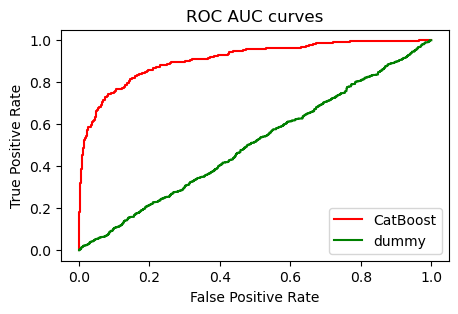

In [40]:
fpr, tpr, _ = roc_curve(y_test, RS_cb.predict_proba(X_test)[:,1]) 
fpr_dummy, tpr_dummy, _ = roc_curve(random.choices([0,1], k=y_test.shape[0]), RS_cb.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, 'r', label='CatBoost')
plt.plot(fpr_dummy, tpr_dummy, 'g', label='dummy')
plt.title('ROC AUC curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Все канонически: у случайной модели, ROC_AUC - прямая и площадь под графиком примерно 0.5, а у нашей хорошей CatBoost модели - площадь под кривой резко возрастает.

In [41]:
print('точность предсказания модели составляет', round(accuracy_score(y_test,  RS_cb.predict(X_test)),2))

точность предсказания модели составляет 0.9


Проведем анализ важности признаков для лучшей модели.

In [42]:
col_names = RS_cb.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
col_importance = RS_cb.best_estimator_._final_estimator.feature_importances_
importance_df = pd.DataFrame([col_names, col_importance]).T.sort_values(by=1, ascending = True)

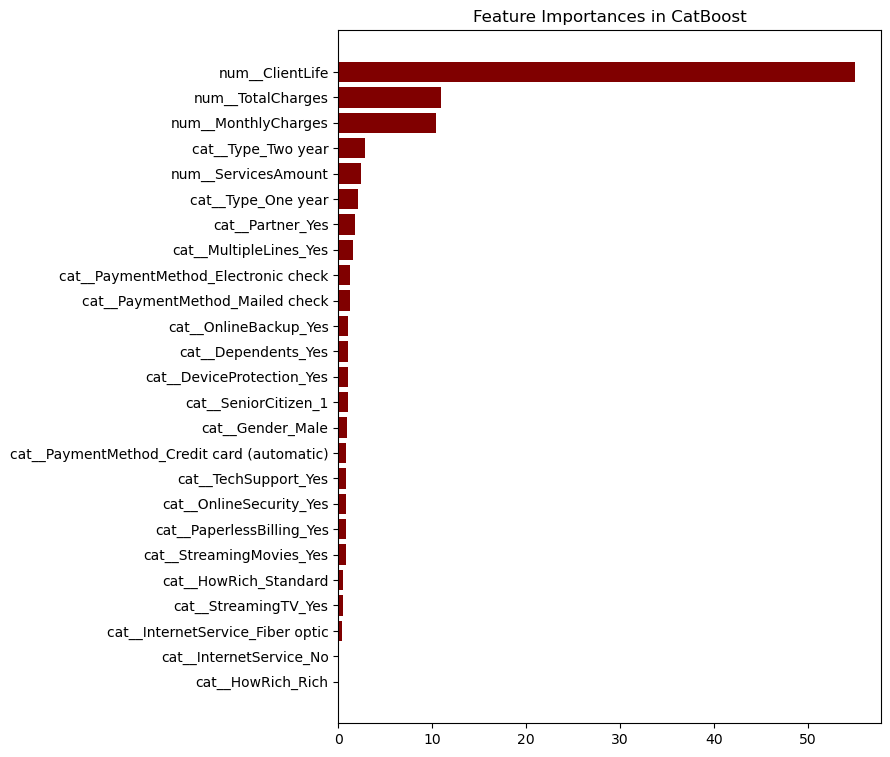

In [43]:
plt.figure(figsize=(7,9))
plt.barh(
    importance_df[0],
    importance_df[1],
    color='maroon', 
)
plt.title('Feature Importances in CatBoost')
plt.show()


  Получилось, что самые важные параметры - это время жизни клиента (это признак существенно обгоняет все остальные по важности) а также общие и месячные траты, тип оплаты и наличие партнера.  

## Вывод
Была проведена подготовка данных для обучения моделей. Подготовка включала в себя:
- Переименование столбцов для приведения к единому виду
- Объединение таблиц по ключевому столбцу customerID
- Заполнение пропусков

Сгенерированы новые признаки: время жизни ушедщих клиентов и количество услуг у всех клиентов.
На основе наличия значений даты окончания контракта, создан целевой бинарный столбец, показывающий, ушел клиент или нет.
Проведен анализ корреляции признаков, оказалось, что в ряде столбцов присутствует мультиколлинеарность. Эти столбцы в дальнейшем не участвовали при построении модели логистической регрессии.В рамках предварительного анализа рассмотрен "портрет" уходящих клиентов: в среднем у них ежемесячная оплата выше, а продолжительность их сотрудничества с оператором - около 3х лет.

Датасет разделен на тренировочный и тестовый с учетом дисбаланса целевого признака, проведены кодировка (а для логистической регрессии и нормировка значений). Обучен ряд моделей, среди которых лучшей оказалась CatBoost.

На кроссвалидации и тренировочной выборке, оценка ROC_AUC достигла 0.91.
На тестовой выборке оценка ROC_AUC и точность модели так же составила 0.91.

## Отчет
1. В процессе выполнения работы были проведены все запланированные шаги и добавлен ряд новых (портрет ушедшего клиента на основе категориальных признаков, анализ важности признаков в лучшей модели).
2. Серьезных затруднений при выполнении проекта не было. Ответы на все возникшие вопросы удалось самостоятельно нагуглить. К таким вопросам относились: как правильно сформировать пайплайн с кодировкой категориальных признаков и нормировкой интервальных, каким образом узнать feature_importance после проведения RandomSearchCV и пайплайна.
3. Ключевые этапы выполнения работы следующие.
    - Загрузка данных и сшивание из них единого датасета (тип объединения inner join, объединять по колонке customer_ID)
    - Проверка на наличие пропусков. Оказалось, что в исходных датасетах пропусков нет, но они появляются в категориальных столбцах, относящимся к различным услугам, когда данные сшиваются в единую таблицу. Такие пропуска все можно заменить на 'No', что символизирует отсутствие соответствующей услуги. Кроме этого, в колонке TotalCharges есть пустые строки (таких записей 11 штук), эти пропуски следует удалить или заменить месячными значениями платежей, результат будет практически одинаков.
    
    - Преобразование типа столбцов. Значения в TotalCharges числовые и должны быть преобразованы в Float, 'BeginDate' и 'EndDate' - в тип datetime.
    
    - Создание новых признаков.
        1. признак "время жизни клиента" (колонка 'ClientLife') - это время, прошедшее от начала договора до его окончания (или, в случае, если договор не закрыт, до даты выгрузки данных, т.е. до 01-02-2020).
        2. признак "количество услуг у клиента" (колонка 'ServicesAmount') - суммарное количество подключенных  услуг (это - 'DeviceProtection','MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'StreamingMovies', 'StreamingTV', 'TechSupport') и дополнительный балл еще тем, кто подключил одновременно и интернет-услуги и телефонию.
        3. целевой признак (колонка 'Betrayer'), на основе 'EndDate': там где дата завершения договора есть, клиент считается ушедшим (значение 1 в 'Betrayer'), там где нет - клиент не ушел  (значение 0 в 'Betrayer').
    
    - Удаление ненужных признаков: 'EndDate' и 'StartDate' (чтобы не было утечки данных), 'CustomerID' - за ненадобностью.
    
    - Исследование распределения целевого признака. Выявило, что есть сильный дисбаланс.
    
    - Подготовка данных для обучения модели: Деление выборки на тренировочную и тестовую (в соотношении 1:4) с учетом дисбаланса целевого признака, параметр random_state = 240423, разделение полученных выборок на целевые и входные.
      
    - Обучение модели. **В качестве модели используется CatBoost, учитывается дисбаланс классов (auto_class_weights='Balanced'), в качестве метрики выбран ROC_AUC. Для обучения модели использованы признаки: 'Type',  'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen',   'Partner',  'Dependents',   'InternetService', 'OnlineSecurity',   'OnlineBackup',   'DeviceProtection',  'TechSupport',  'StreamingTV',  'StreamingMovies',  'MultipleLines', 'ServicesAmount', 'MonthlyCharges', 'TotalCharges', 'ClientLife'**
        - Создание пайплайна, в котором категориальные признаки кодируются методом OHE.
        - Инициализация диапазона значений параметров для оптимизации:     'model__iterations': range(650, 800, 5), 'model__learning_rate': np.logspace(-1, 0, 20), 'model__depth': range(4, 6, 1). Изначально диапазон значений параметров был шире, а шаг изменения - больше, потом было проведено несколько итераций обучения модели с сужением диапазона значений и уменьшением шага для более аккуратного поиска оптимальных значений.
        - Проведение RandomizedSearchCV с числом фолдов равным пяти.
        - В результате этого шага **получена модель, с оптимальными параметрами 'model__learning_rate': 0.16237767391887217, 'model__iterations': 760, 'model__depth': 4**.
            Оценка ROC_AUC на кроссвалидации достигла 0.91.
    
    - Финальная апробация модели на тестовой выборке, сравнение с дамми-моделью и визуализация Auc-roc кривой подтвердили качество модели. 
    

4. Кроме перечисленных ключевых этапов, были проделаны дополнительные действия, существенно не влияющие на результат, но которые сделали анализ удобным, а также более детальным и разносторонним. К этим пунктам относится:

    - Приведение названий свойств к общему стилистическому виду
    - Предварительный анализ данных с визуализацией распределения признаков
    - Создание «портрета» уходящих клиентов. Чаще уходят те:
        - у кого есть партнер
        - кто делает бекап и защиту устройств
        - у кого несколько параллельных телефонных линий
        - кто смотрит стриминговые видео</br>
            А вот те, кто платят ежемесячно или по чеку (электронному или почтовому) - уходят реже, чем те кто имеют годовой(двухгодичный) тип оплаты и пользуется банковским переводом/кредитной картой.
    - Анализ важности признаков в обученной модели

- проведение корреляционного анализа с помощью библиотеки Phik. В результате выявлена существенная кросскорреляция между колонками InternetService/MonthlyCharges (0.92), TotalCharges/ClientLife(0.85), MonthlyCharges/StreamingMovies и StreamingTV (0.83 и 0.84).
- Проведено тестирование различных моделей, в том числе логистической регрессии (для которой мультиколлинеарные столбцы были удалены, проведена кодировка категориальных и нормировка интервальных признаков), деревянных моделей, LGBM и классификации методом ближайших соседей. 
    

5. Проведено исследование важности признаков (future importance) обученной модели. К определяющим признакам относятся: время жизни клиента (это признак существенно обгоняет все остальные по важности) а также общие и месячные траты, тип оплаты и наличие партнера. Это позволяет сделать вывод о том, что телеком-компании для минимизации количества ушедших клиентов следует обратить внимание на тех, кто в "зоне риска": у кого есть партнер, а средние месячные траты составляют около 100 у.е.

